In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import dask.dataframe as dd
import dask.array as da
import dask.distributed
import geopandas as gpd
import pandas as pd
import numpy as np
import iris, iris.plot

import sklearn
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm as symlog
from matplotlib import rcParams
import seaborn as sns
import palettable
sns.set_style('white')

client = dask.distributed.Client()

In [2]:
rcParams['font.sans-serif'] = ('Helvetica', 'Arial', 'Open Sans', 'Bitstream Vera Sans')
rcParams['font.size'] = 12
rcParams['font.stretch'] = 'normal'
rcParams['font.weight'] = 'normal'

import os.path
homedirpath = os.path.expanduser('~')
fontdirpath = ''
if '/Users/' in homedirpath:
    fontdirpath = os.path.join(homedirpath, 'Library/Fonts/')
else:
    fontdirpath = os.path.join(homedirpath, '.fonts/')
fontsize2 = 'size={0:0.1f}'.format(12)
rcParams['mathtext.it'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaOblique.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.rm'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.tt'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.bf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaBold.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.cal'] = ((':family=sans-serif:style=normal:variant='
                             'normal:weight=normal:stretch=normal:file='
                             '{0}/Helvetica.ttf:' +
                             fontsize2
                             ).format(fontdirpath))
rcParams['mathtext.sf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))

In [3]:
bike = dd.read_parquet('/data/citibike.parquet', engine='fastparquet')

In [4]:
bike = bike.set_index('start_time', npartitions=64)

In [5]:
bike.to_parquet('/data/citibike_start_time_indexed.parquet', compression='SNAPPY', has_nulls=True, object_encoding='json')

In [6]:
bike = dd.read_parquet('/data/citibike_start_time_indexed.parquet', engine='fastparquet')

In [29]:
bike2=bike[['start_station_id', 'end_station_id']]

In [30]:
z = bike2.sample(frac=0.1, random_state=42).compute()

In [8]:
def feature_engineer_times(df):
    df2 = pd.DataFrame(index=df.index)
    df2['hours_till_next_business_hour'] = ((((df.index +  pd.tseries.offsets.BusinessHour(.01)) 
                                              - df.index).total_seconds())/3600.)
    

In [9]:
z.index.weekofyear

Int64Index([27, 28, 29, 28, 28, 28, 29, 28, 28, 27,
            ...
            50, 51, 50, 52, 50, 51, 52, 50, 52, 51],
           dtype='int64', name='start_time', length=369021)

In [10]:
(z.index.dayofyear / 365.) + (z.index.hour / 24./365.) + (z.index.minute / 60. / 24. / 365.)

Float64Index([ 0.50024543379, 0.519990487062, 0.550034246575, 0.520258751903,
                        0.52, 0.527566590563, 0.549305555556, 0.521822678843,
              0.518531202435, 0.503027016743,
              ...
              0.956889269406, 0.977199391172, 0.957132800609, 0.993417047184,
              0.961504946728, 0.977781582953, 0.999227549467, 0.961065449011,
              0.993864155251, 0.974908675799],
             dtype='float64', name='start_time', length=369021)

In [11]:
(z.index.hour / 24.) + (z.index.minute / 60. / 24. )

Float64Index([0.589583333333, 0.796527777778,         0.7625, 0.894444444444,
                         0.8, 0.561805555556, 0.496527777778, 0.465277777778,
              0.263888888889, 0.604861111111,
              ...
              0.264583333333, 0.677777777778, 0.353472222222, 0.597222222222,
              0.949305555556, 0.890277777778, 0.718055555556, 0.788888888889,
              0.760416666667, 0.841666666667],
             dtype='float64', name='start_time', length=369021)

In [12]:
(z.index.minute / 60. )

Float64Index([          0.15, 0.116666666667,            0.3, 0.466666666667,
                         0.2, 0.483333333333, 0.916666666667, 0.166666666667,
              0.333333333333, 0.516666666667,
              ...
                        0.35, 0.266666666667, 0.483333333333, 0.333333333333,
              0.783333333333, 0.366666666667, 0.233333333333, 0.933333333333,
                        0.25,            0.2],
             dtype='float64', name='start_time', length=369021)

In [13]:
# d_df['weekday_name'] = d_df.map_partitions(lambda l: l.index.weekday_name, meta=('asdf', str))
# d_df['bday_forward'] = d_df.map_partitions(lambda l: (l.index+pd.tseries.offsets.BusinessHour(1)) - (l.index), meta=('asdf', 'M8[ns]'))

/home/shekhar/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


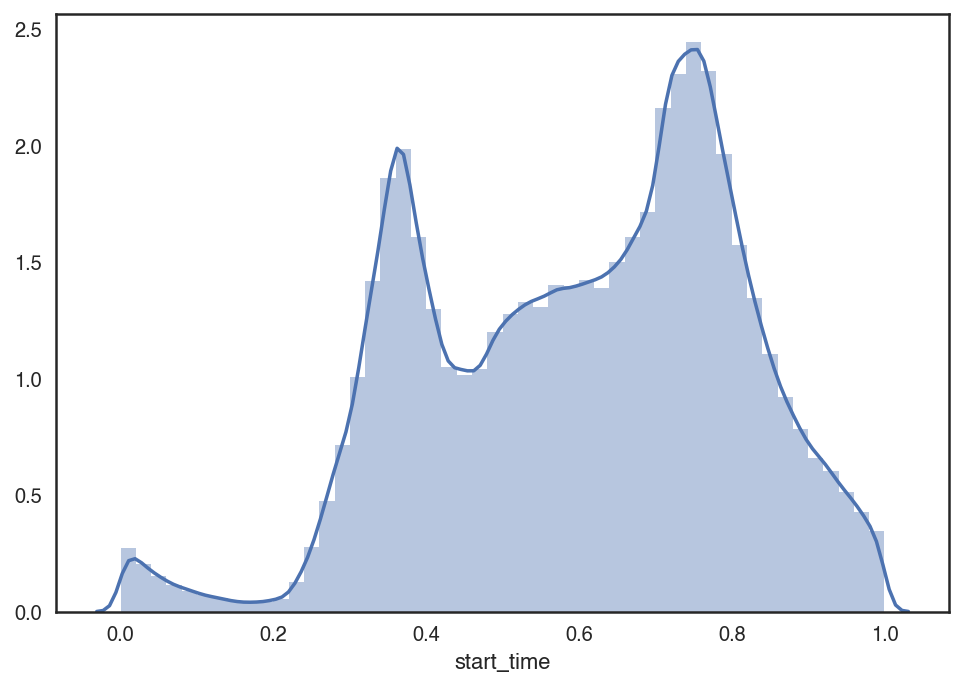

In [31]:
sns.distplot((z.index.hour / 24.) + (z.index.minute / 60. / 24. ))

/home/shekhar/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


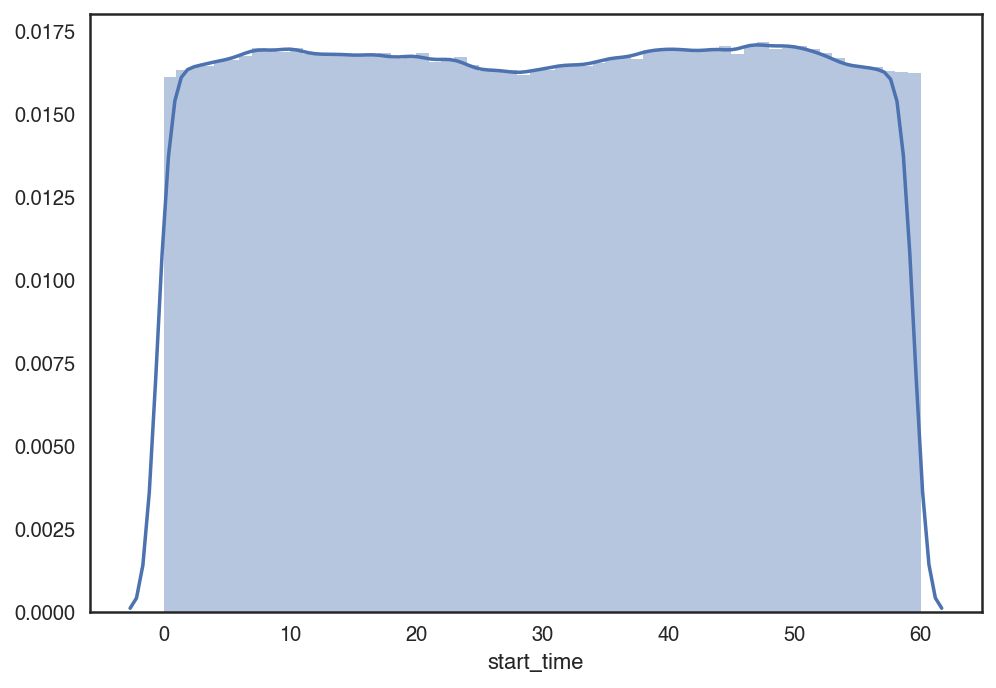

In [32]:
sns.distplot(z.index.minute, bins=np.linspace(0, 61, 62))

/home/shekhar/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


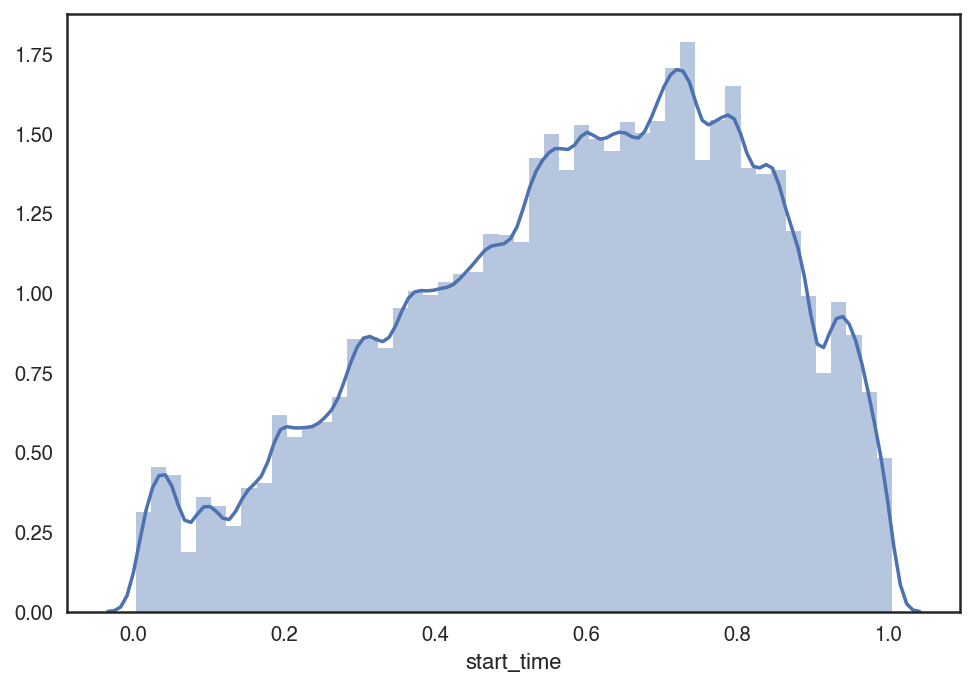

In [33]:
sns.distplot((z.index.dayofyear / 365.) + (z.index.hour / 24./365.) + (z.index.minute / 60. / 24. / 365.))

(-0.041666666666666664, 7.041666666666667)

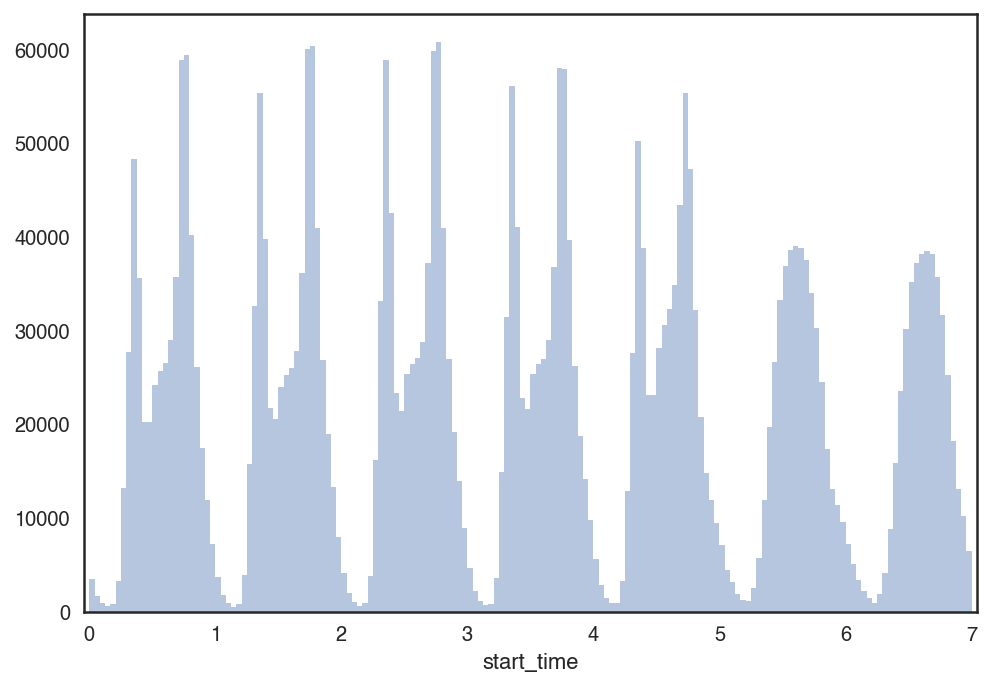

In [35]:
sns.distplot(z.index.dayofweek + z.index.hour / 24. + (z.index.minute / 60./ 24. ), bins=np.arange(0., 7.041666666, 1/24.)
            , kde=False, norm_hist=False)
plt.xlim(-1/24., 7.+1/24.)

/home/shekhar/anaconda3/lib/python3.5/site-packages/pandas/core/indexes/datetimes.py:831: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)
/home/shekhar/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


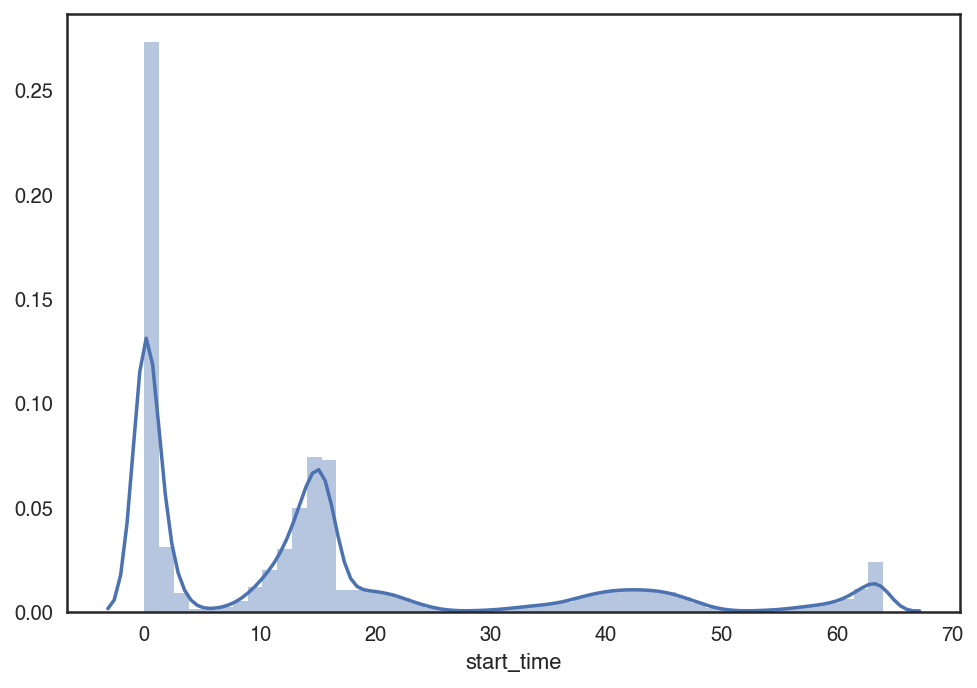

In [18]:
sns.distplot((((z.index +  pd.tseries.offsets.BusinessHour(1)) 
                                              - z.index).total_seconds() - 3600.)/3600.)

/home/shekhar/anaconda3/lib/python3.5/site-packages/pandas/core/indexes/datetimes.py:831: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)
/home/shekhar/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


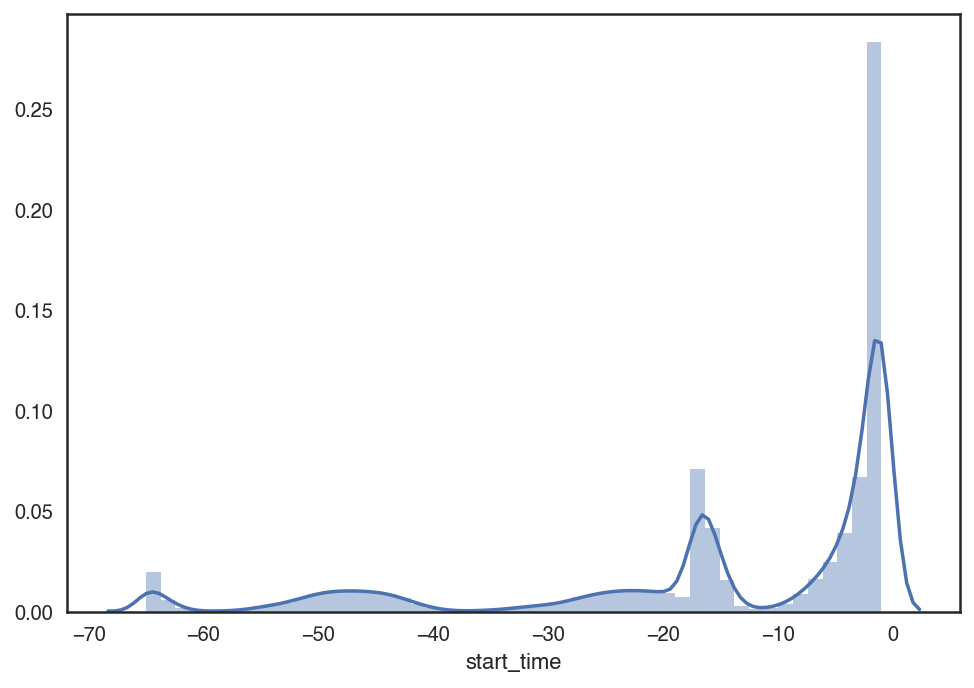

In [19]:
sns.distplot((((z.index +  pd.tseries.offsets.BusinessHour(-1)) 
                                              - z.index).total_seconds())/3600.)

In [ ]:
mm = pd.DataFrame(index=z.index)
mm['prev'] = z.index + pd.tseries.offsets.BusinessHour(1)

/home/shekhar/anaconda3/lib/python3.5/site-packages/pandas/core/indexes/datetimes.py:831: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)
/home/shekhar/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


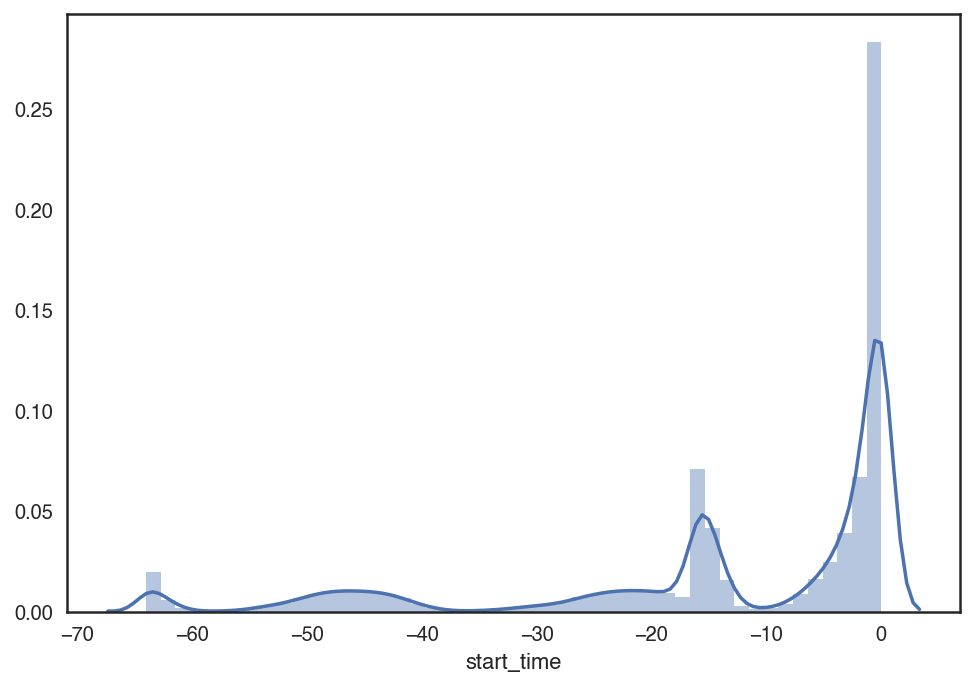

In [20]:
sns.distplot((((z.index + pd.tseries.offsets.BusinessHour(-1)) - z.index).total_seconds() + 3600.)/ 3600.)

In [39]:
import iris, iris.plot, cartopy, cartopy.crs

In [37]:
t2, = iris.load('/bigdata/merra2/T2M.nc')

/home/shekhar/anaconda3/lib/python3.5/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [58]:
prectotcorr, = iris.load('/bigdata/merra2/PRECTOTCORR.nc')
speed, = iris.load('/bigdata/merra2/SPEED.nc')

/home/shekhar/anaconda3/lib/python3.5/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/home/shekhar/anaconda3/lib/python3.5/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [43]:
bike.head()

,trip_duration,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,start_taxizone_id,end_taxizone_id
start_time,,,,,,,,,,,,,,,,
2013-07-01 00:00:00,634,2013-07-01 00:10:34,164,E 47 St & 2 Ave,40.753231,-73.970325,504,1 Ave & E 15 St,40.732219,-73.981656,16950,Customer,NaN,0,233.0,224.0
2013-07-01 00:00:02,1547,2013-07-01 00:25:49,388,W 26 St & 10 Ave,40.749718,-74.002950,459,W 20 St & 11 Ave,40.746745,-74.007756,19816,Customer,NaN,0,246.0,246.0
2013-07-01 00:01:04,178,2013-07-01 00:04:02,293,Lafayette St & E 8 St,40.730287,-73.990765,237,E 11 St & 2 Ave,40.730473,-73.986724,14548,Subscriber,1980.0,2,113.0,79.0
2013-07-01 00:01:06,1580,2013-07-01 00:27:26,531,Forsyth St & Broome St,40.718939,-73.992663,499,Broadway & W 60 St,40.769155,-73.981918,16063,Customer,NaN,0,148.0,142.0
2013-07-01 00:01:10,757,2013-07-01 00:13:47,382,University Pl & E 14 St,40.734927,-73.992005,410,Suffolk St & Stanton St,40.720664,-73.985180,19213,Subscriber,1986.0,1,113.0,148.0


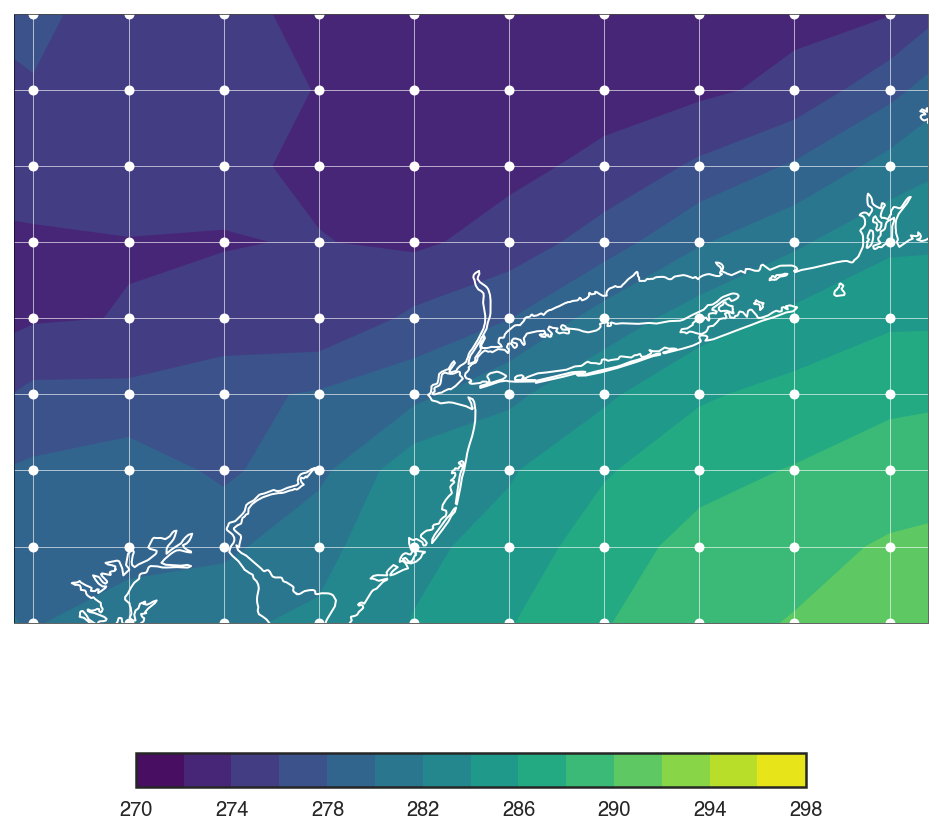

In [74]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines(color='white', resolution='10m')

iris.plot.contourf(t2[0], axes=ax, cmap=plt.cm.viridis, levels=np.arange(270, 300, 2))
plt.colorbar(orientation='horizontal', shrink=0.5)

for x in t2.coord('longitude').points:
    ax.axvline(x, color='white', lw=0.3)

for y in t2.coord('latitude').points:
    ax.axhline(y, color='white', lw=0.3)

x, y = np.meshgrid(t2.coord('longitude').points, t2.coord('latitude').points)
plt.plot(x.ravel(), y.ravel(), 'o', markersize=5, color='white')
    
plt.sca(ax)
ax.set_xlim(-77, -71)
ax.set_ylim(39, 43)
plt.gcf().set_size_inches(12, 8)

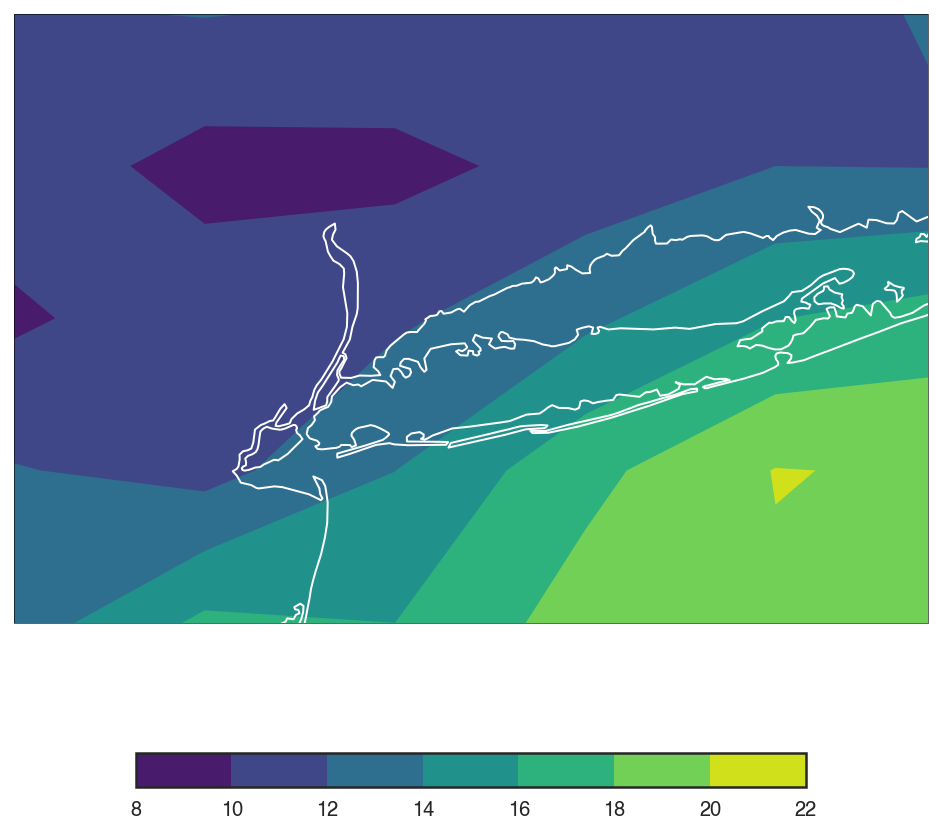

In [63]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines(color='white', resolution='10m')

iris.plot.contourf(speed[0], axes=ax, cmap=plt.cm.viridis, levels=np.arange(8, 24, 2))
plt.colorbar(orientation='horizontal', shrink=0.5)

plt.sca(ax)
ax.set_xlim(-75, -72)
ax.set_ylim(40, 42)
plt.gcf().set_size_inches(12, 8)

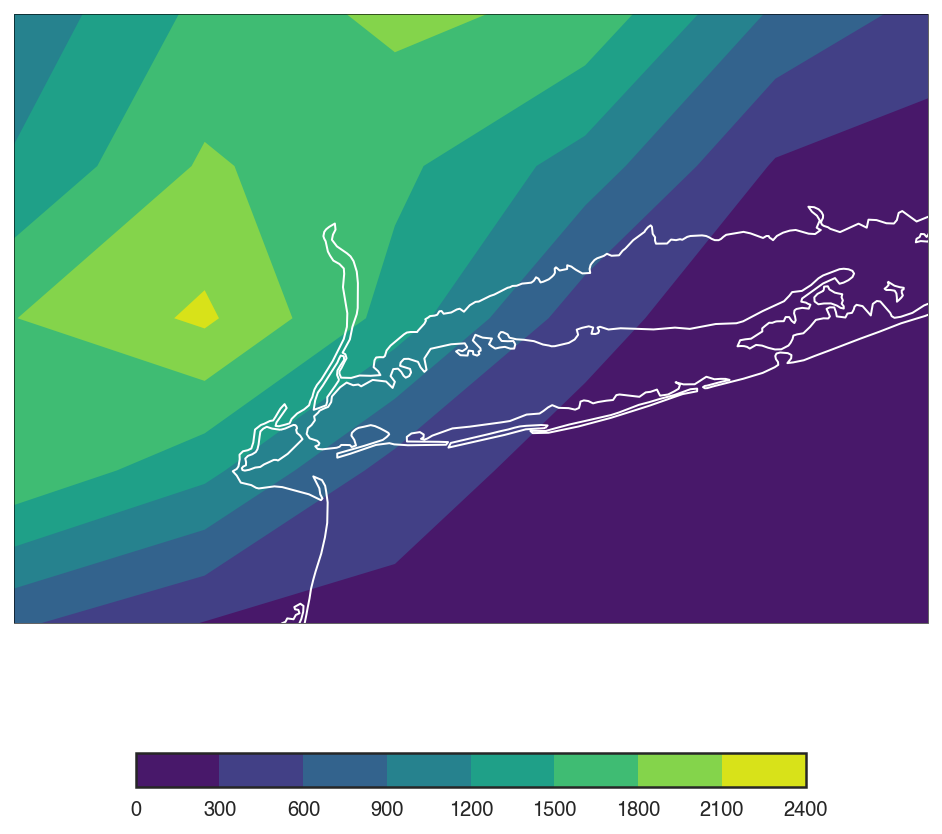

In [68]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines(color='white', resolution='10m')

iris.plot.contourf(prectotcorr[3]*86400*24, axes=ax, cmap=plt.cm.viridis)
plt.colorbar(orientation='horizontal', shrink=0.5)

plt.sca(ax)
ax.set_xlim(-75, -72)
ax.set_ylim(40, 42)
plt.gcf().set_size_inches(12, 8)